In [139]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

In [106]:
df_calendar = pd.read_csv('calendar.csv')
df_listings = pd.read_csv('listings.csv')
df_reviews = pd.read_csv('reviews.csv')

In [107]:
df_calendar.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


In [108]:
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [133]:
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


### data wrangling and exploration

#### explore df_calendar dataframe

In [110]:
# drop rows if column available is f
df_calendar = df_calendar[df_calendar['available']=='t']

In [111]:
# to get a sense of data. how many and what columns do we have? How many rental houses are there? 
df_calendar_listing_id = df_calendar['listing_id'].value_counts().sort_values()
print("there are {} houses available in this dataset".format(len(df_calendar_listing_id)))

there are 2906 houses available in this dataset


In [112]:
# What is the time span of the dataset?
print("the time span for each house ranges from {} to {}".format(df_calendar['date'].min(),
                                                                df_calendar['date'].max()))

the time span for each house ranges from 2016-09-06 to 2017-09-05


In [113]:
# is there a price fluctuation as season changes? //future to-dos

#### clean df_listings dataframe

In [114]:
# there are too many columns in df_listings dataframe, a subset is selected for further analysis.
selected_features = ['description','accommodates','bathrooms',
                     'bedrooms','beds','price','minimum_nights','number_of_reviews',
                     'review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness',
                     'review_scores_checkin', 'review_scores_communication',
                     'review_scores_location', 'review_scores_value']
df_listings = df_listings[selected_features]

In [115]:
# percentage of available houses
percentage = float("{0:.2f}".format(len(df_calendar_listing_id)/len(df_listings)))
print(f"percentage of availble houses:{percentage}")

percentage of availble houses:0.81


In [116]:
# delete rows without overall ratings.
df_listings = df_listings[df_listings['review_scores_rating'].notnull()]
# fill 0 to nan values of room layout related features
room_layout_columns = ['accommodates','bathrooms','bedrooms','beds']
df_listings[room_layout_columns] = df_listings.fillna(0)[room_layout_columns]
# interpolate missing values of subcategory reviews.
sub_review_columns = ['review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
                     'review_scores_communication','review_scores_location','review_scores_value']
df_listings[sub_review_columns] = df_listings.interpolate(axis=0)[sub_review_columns]
# the format price column
def price_mapper(price):
    price = price.replace('$','')
    price = price.replace(',','')
    return float(price)

df_listings['price'] = df_listings['price'].map(price_mapper)

#### plot price distribution

house average rental price is 166.7
house median rental price is 145.0


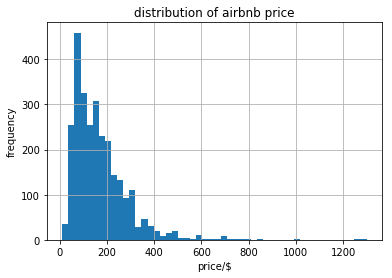

In [117]:
# price distribution
df_listings['price'].hist(bins=50)
plt.title('distribution of airbnb price')
plt.xlabel('price/$')
plt.ylabel('frequency')

price_mean = "{0:.1f}".format(df_listings['price'].mean())
price_median = df_listings['price'].median()
print(f'house average rental price is {price_mean}')
print(f'house median rental price is {price_median}')

#### what are popularities of various kinds of room layout?

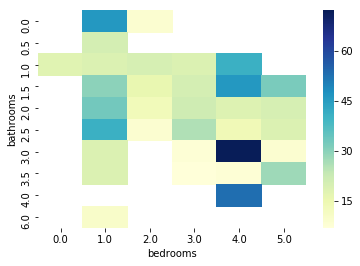

In [166]:
# filter rows with at least 5 reviews 

grouped = df_listings_legit.groupby(['bathrooms','bedrooms'])

df_popularity_heatmap = grouped['number_of_reviews'].median().sort_values()
df_popularity_heatmap = pd.DataFrame(df_popularity_heatmap)
df_popularity_heatmap = df_popularity_heatmap.reset_index(level=['bathrooms', 'bedrooms'])
df_popularity_pivot = df_popularity_heatmap.pivot(index='bathrooms', columns='bedrooms', values='number_of_reviews')
sns.heatmap(df_popularity_pivot, cmap="YlGnBu")

#### what types of room layour receive highest ratings?

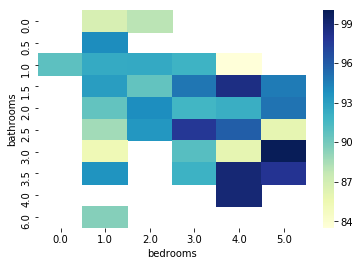

In [175]:
# filter rows with at least 5 reviews 
df_listings_legit = df_listings[df_listings['number_of_reviews']>=3]

grouped = df_listings_legit.groupby(['bathrooms','bedrooms'])
df_rating_heatmap = grouped['review_scores_rating'].mean().sort_values()
df_rating_heatmap = pd.DataFrame(df_rating_heatmap)
df_rating_heatmap = df_rating_heatmap.reset_index(level=['bathrooms', 'bedrooms'])
df_rating_pivot = df_rating_heatmap.pivot(index='bathrooms', columns='bedrooms', values='review_scores_rating')
sns.heatmap(df_rating_pivot, cmap="YlGnBu")

In [129]:
# define a function to generate wordcloud.
from functools import reduce
def generate_wordcould(text_list):
    text = reduce((lambda x, y: x+y), text_list)
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

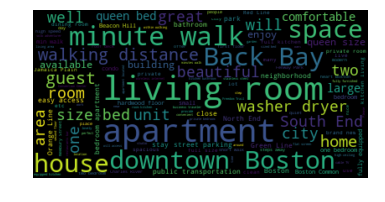

In [130]:
# get vocabulary of reviews from house descriptions.
generate_wordcould(df_listings['description'])

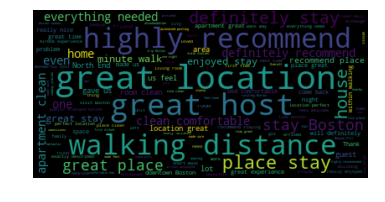

In [134]:
# get vocabulary of reviews from df_reviews
df_reviews = df_reviews[df_reviews['comments'].notnull()]
generate_wordcould(df_reviews['comments'])

In [10]:
# cancatenate the dataframes if necessary.


### feature engineering

### modelling  
To understand how different factors effect the rental price of airbnb house. A regression model is needed to be built. With that model in hand, landlords could use it to set competitive prices for their houses, and tenets could also check if the price of houses they are going to live in is reasonable.

### clustering
Can we have a better understanding of what characteristics houses in airbnb have if we categorize them 
into several clusters?

### deploy (future work)  
To build a website for predicting airbnb rental price. The front end serves to collect data from users,
and back end is put to run trained model and a user could get a rental price based on his inputs.